In [4]:
import networkx as nx
import math
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm

In [5]:
data = sio.loadmat('Data.mat')['D']
print(data.shape)
df = pd.DataFrame(data)
df.head()

(10000, 8)


,0,1,2,3,4,5,6,7
0,0.110542,1.042710,-1.575183,1.055074,-0.148899,1.062382,0.116945,-0.244467
1,1.397050,0.257278,-0.351936,-0.232494,1.344092,-0.060821,0.387983,1.618541
2,0.690281,1.321500,1.417502,0.982115,-0.716820,-0.508841,-1.768362,2.926619
3,-0.634045,-1.255488,-0.578344,-0.305612,0.273759,0.533964,-1.647791,-0.963040
4,-0.376387,0.863437,-0.296768,0.625518,-0.577722,0.855256,2.067983,-0.582378


In [6]:
G = nx.Graph()
vertex_set = [i for i in range(df.shape[1])]

In [7]:
for v in vertex_set:
    G.add_node(v)

# Implementation of PC pop Algorithm

In [8]:
def nodes_connected(u, v):
    return u in G.neighbors(v)

In [9]:
def compute_pairs():
    adj_vertices = []
    for i in range(len(vertex_set)):
        for j in range(i+1, len(vertex_set)):
            if nodes_connected(vertex_set[i], vertex_set[j]):
                adj_vertices.append((vertex_set[i], vertex_set[j]))
    return adj_vertices

In [10]:
def remove_in_adj(x, y):
    result = set()
    for i in G.adj[x]:
        if i != y:
            result.add(i)
    return result

In [11]:
def compute_subsets(set_, k):
    return list(itertools.combinations(set_, k))

In [12]:
def finished(d):
    all_done = True
    for (x, y) in compute_pairs():
        new_adj_set = remove_in_adj(x, y)
        if len(new_adj_set) >= d:
            all_done = False
    return all_done

In [14]:
# Conditional independence test
def gaussCItest(suffStat, x, y, S):
    C = suffStat["C"]
    n = suffStat["n"]

    cut_at = 0.9999999

    # bias coefficient (math.)
    # There's no nodes in S.
    if len(S) == 0:
        r = C[x, y]

    # There's only one node in S, the first-order bias correlation coefficient.
    elif len(S) == 1:
        r = (C[x, y] - C[x, S] * C[y, S]) / math.sqrt((1 - math.pow(C[y, S], 2)) * (1 - math.pow(C[x, S], 2)))

    # I actually don't quite understand what's being begged here, 
    # but that's what the pcalg package for the R language says
    else:
        #print(x, y, list(S))
        m = C[np.ix_([x]+[y]+list(S), [x]+[y]+list(S))]
        PM = np.linalg.pinv(m)
        r = -1 * PM[0, 1] / math.sqrt(abs(PM[0, 0] * PM[1, 1]))

    r = min(cut_at, max(-1*cut_at, r))
    # Fisher’s z-transform
    res = math.sqrt(n - len(S) - 3) * .5 * math.log1p((2 * r) / (1 - r))
    # Φ^{-1}(1-α/2)
    return 2 * (1 - norm.cdf(abs(res)))

In [35]:
def pc_pop_algo(vertex_set, df, alpha):
    #First step: Construct the complete undirected graph on the vertex set V
    for i in range(len(vertex_set)):
        for j in range(i+1, len(vertex_set)):
            G.add_edge(vertex_set[i], vertex_set[j])
            
    nx.draw(G, with_labels = True)
    
    #Second step: Perform conditional independence tests at a given significance level α 
    #and delete edges based on the tests.
    d = 0
    all_done = False
    separation_sets = {}
    
    # Sufficient Statistic
    n = df.values.shape[0]
    C = df.corr().values
    suffStat={"C": C, "n": n}
    
    while not finished(d):
        for (x, y) in compute_pairs():
            new_adj_set = remove_in_adj(x, y)
            if len(new_adj_set) >= d:
                for z in compute_subsets(new_adj_set, d):
                    #Test conditional independance I(x, y | z) and remove edge
                    pVal = gaussCItest(suffStat, x, y, z)
                    threshold = norm.pdf(1 - alpha/2)**(-1) / math.sqrt(n - len(z) - 3)
                    if pVal > threshold :
                        G.remove_edge(x,y)
                        if (x, y) not in separation_sets:
                            separation_sets[(x, y)] = z
                            separation_sets[(y, x)] = z
                        else:
                            separation_sets[(x, y)].append(z)
                            separation_sets[(y, x)].append(z)
        d = d + 1
    return G, separation_sets 

# Plot after PC-Algorithm

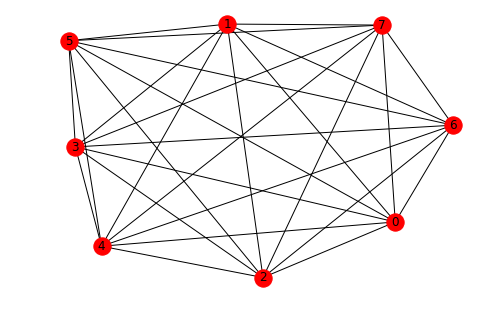

In [36]:
G_new, separation_sets = pc_pop_algo(vertex_set, df, 0.5)

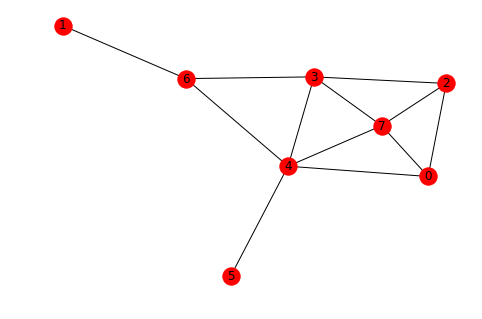

In [37]:
# Plot of the graph G for the observational data after PC-Algorithm.
nx.draw(G_new, with_labels = True)

# Meek Rules

In [77]:
list(nx.common_neighbors(G_new, 0, 6))

[4]

In [104]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [175]:
def meek_rules(G_skel, separation_sets):
    #orient v structures : third part in the project pdf
    G_skel_copy = G_skel.copy()
    G_skel_directed = G_skel_copy.to_directed()
    for i in range(len(vertex_set)):
        for j in range(i + 1, len(vertex_set)):
                if not nodes_connected(vertex_set[i], vertex_set[j]):
                    common_neighbors = list(nx.common_neighbors(G_skel, vertex_set[i], vertex_set[j]))
                    if len(common_neighbors) > 0:
                        for k in common_neighbors:
                            if k in separation_sets[(vertex_set[i], vertex_set[j])]:
                                if G_skel_directed.has_edge(k, vertex_set[i]) and G_skel_directed.has_edge(k, vertex_set[j]):
                                    G_skel_directed.remove_edge(k, i)
                                    G_skel_directed.remove_edge(k, j)
    #Now work with as many undirected edges possible
    #Apply meek rules on all remaining undirected edges
    for i in range(len(vertex_set)):
        for j in range(i + 1, len(vertex_set)):
            x, y = vertex_set[i], vertex_set[j]
            #If the two are linked by two edges = undirected edges
            if G_skel_directed.has_edge(x, y) and G_skel_directed.has_edge(y, x):
                #R1
                in_edges_x = list(G_skel_directed.in_edges(x))
                if len(in_edges_x) > 1:
                    for e in in_edges_x:
                        if not nodes_connected(e[0], y):
                            if G_skel_directed.has_edge(y, x):
                                G_skel_directed.remove_edge(y, x)
                #R2
                out_edges_x = map(lambda x: x[1], list(G_skel_directed.out_edges(x)))
                in_edges_y = map(lambda x: x[0], list(G_skel_directed.in_edges(y)))
                if len(set(out_edges_x).intersection(set(in_edges_y))) > 0:
                    if G_skel_directed.has_edge(y, x):
                        G_skel_directed.remove_edge(y, x)
                #R3
                
                        
                #R4
    
    nx.draw(G_skel_directed, with_labels = True)

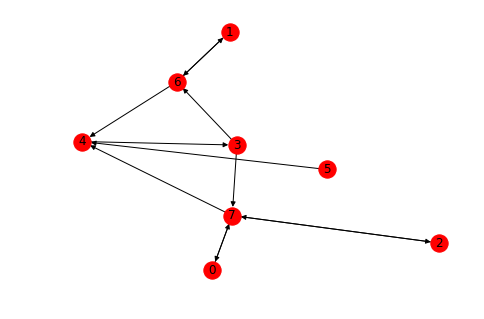

In [176]:
meek_rules(G_new, separation_sets)